# Analysis of the Bosch data set

This notebook analyzes the Bosch data set and extracts meta-data for further processing from it.


The initial labelling file `Bosch-BBox-Labels.csv` contains 16.133 instances with the following data (per row):
* Filename
* Width
* Height
* Roi.X1
* Roi.Y1
* Roi.X2
* Roi.Y2
* ClassId    

---
### 1) Import and Preview

In [1]:
import pandas as pd
import matplotlib as mlp
import numpy as np

from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('Bosch-BBox-Labels.csv')
df.head()  # prints top 5 rows

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00001.png,640,480,5,174,49,209,107
1,00001.png,640,480,364,167,412,212,109
2,00002.png,640,480,5,174,49,209,107
3,00002.png,640,480,364,167,412,212,109
4,00003.png,640,480,5,174,49,209,107


---
### 2) Plotting the Label Distribution

1. First plot shows the distribution over the full dataset (including 'empty' images).
2. Second plot illustrates the true label distribution.
3. Additional data about the data set (min, max, exact class distribution)

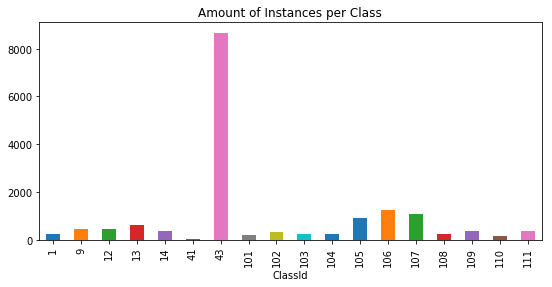

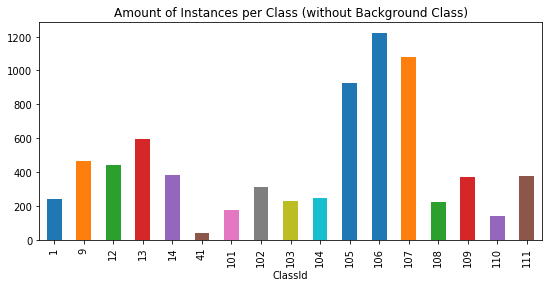

  Total Amount: 16134
Minimum Amount: 41
Maximum Amount: 8669
 Without empty: 7465

    ClassId  Amount
0         1     242
1         9     466
2        12     440
3        13     596
4        14     381
5        41      41
6        43    8669
7       101     175
8       102     311
9       103     228
10      104     248
11      105     924
12      106    1224
13      107    1077
14      108     221
15      109     372
16      110     141
17      111     378


In [3]:
# 1) Plot the distribution (with background class).
grouped_classes = df.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
grouped_classes.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class', legend=False)
plt.show()

# 2) Plot without background class.
df_without_background = df.drop(df[df['ClassId'] == 43].index)
df_without_background_grouped = df_without_background.groupby('ClassId').count()['Width']
df_without_background_grouped.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class (without Background Class)', legend=False)
plt.show()
df_without_background_grouped = df_without_background_grouped.reset_index()
df_without_background_grouped.columns = ['ClassId', 'Amount']

# 3) Print statistics.
grouped_classes = grouped_classes.reset_index()  # Makes the index go from 0-17.
grouped_classes.columns = ['ClassId', 'Amount']  # Column renaming
print("  Total Amount: {}".format(grouped_classes['Amount'].sum()))
print("Minimum Amount: {}".format(grouped_classes['Amount'].min()))
print("Maximum Amount: {}".format(grouped_classes['Amount'].max()))
print(" Without empty: {}\n".format(grouped_classes['Amount'].sum() - grouped_classes['Amount'].max()))
print(grouped_classes)

---
### 3) Mapping between the ClassIDs and the Stree Sign Names

In [4]:
# Map ClassId : SignName
signs = {1:'spee_limit_30_begin',
         9:'no_overtaking_begin',
         12:'priority_road',
         13:'give_way',
         14:'stop',
         41:'no_overtaking_end',
         43:'?None',
         101:'speed_limit_30_end',
         102:'pedestrian_crossing',
         103:'sharp_turn_left',
         104:'even_sharper_turn_left',
         105:'shart_turn_right',
         106:'even_shart_turn_right',
         107:'step_downhill_10',
         108:'step_uphill_10',
         109:'parking_zone',
         110:'expressway_begin',
         111:'expressway_end'}


---
### 4) Clean for "Time-Axis"

Since all images are taken from a video with 30 fps, most of them show the same scene (even the same pixels with little to no difference to the previous images). This is especially obvious if you inspect a series of images belonging to the same street sign. As a consequence those images yield no variety during training (no generalization) and only amplify overfitting.

Therefore, we want to get as much **distinct** images as possible. A trivial approach to achieve this, is to drop all images that are too *close in time* to a *base image*. E.g. a 2 second scene showing a *give way* sign, which corresponds to ~60 images. Given the heuristic, we drop x images that are too close to *image y*. x being 15 and y being the first image in this series, we would only keep the images [1, 16, 31, 46].

In [5]:
# We want to distinguish between images that are to close to one another in time .
# e.g. mulitple images from the same 1 second long video snippet.


# We want to get the frame time.
df_clean = df
df_clean['TrackFrame'] = df_clean['Filename']  # Copy the Filename column.
df_clean['TrackFrame'] = df_clean['TrackFrame'].str.extract('(\d{5})', expand=True).astype(int)  # Extract the frame sequence number.

classes = df_without_background_grouped['ClassId'].values  # Get all ClassIds (without background)

amount_keep = dict((cl, 0) for cl in classes)
amount_drop = dict((cl, 0) for cl in classes)

index_to_drop = []

for cl in classes:
    track_frames = df_clean[df_clean['ClassId'] == cl]['TrackFrame'].values  # Get all FrameIDs.
    
    running_track_frame = 0
    keep_amount, drop_amount = 0, 0
    
    for track_frame in track_frames:
        if (track_frame - running_track_frame) > 15:  # entries to keep
            running_track_frame = track_frame
            keep_amount += 1
        else:  # entries to drop
            to_drop = df_clean[(df_clean['ClassId'] == cl) & (df_clean['TrackFrame'] == track_frame)]
            drop_amount += 1
            index_to_drop.append(to_drop.index.values[0])
    
    amount_keep[cl] = keep_amount
    amount_drop[cl] = drop_amount

df_clean = df_clean.drop(df_clean.index[sorted(index_to_drop)])
df_clean = df_clean.drop(df_clean[df_clean['ClassId'] == 43].index)
        
print("Images per class that are being kept: ", amount_keep)
print("\nImages per class that are being droped: ", amount_drop)

print("\nImage-Count before: {}".format(len(df_without_background)))
print("Image-Count after:  {}".format(len(df_clean)))

Images per class that are being kept:  {1: 17, 101: 12, 102: 22, 103: 15, 104: 17, 105: 62, 106: 81, 107: 69, 12: 30, 13: 40, 14: 25, 109: 23, 108: 15, 9: 31, 110: 11, 41: 3, 111: 27}

Images per class that are being droped:  {1: 225, 101: 163, 102: 289, 103: 213, 104: 231, 105: 862, 106: 1143, 107: 1008, 12: 410, 13: 556, 14: 356, 109: 349, 108: 206, 9: 435, 110: 130, 41: 38, 111: 351}

Image-Count before: 7465
Image-Count after:  500


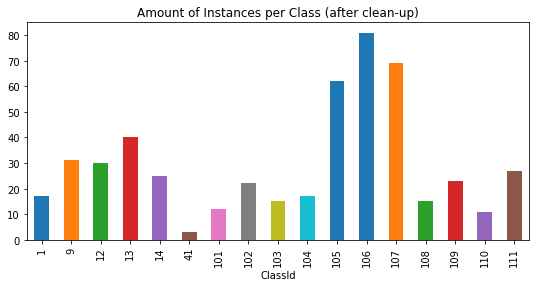

ClassId
1      17
9      31
12     30
13     40
14     25
41      3
101    12
102    22
103    15
104    17
105    62
106    81
107    69
108    15
109    23
110    11
111    27
Name: Width, dtype: int64


In [7]:
df_clean_plot = df_clean.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
df_clean_plot.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class (after clean-up)', legend=False)
plt.show()

print(df_clean_plot)